# 1. Preparation

## Clone model's git

In [1]:
!git clone https://github.com/zhouhaoyi/Informer2020.git

Cloning into 'Informer2020'...
remote: Enumerating objects: 560, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 560 (delta 10), reused 15 (delta 4), pack-reused 535
Receiving objects: 100% (560/560), 6.48 MiB | 18.60 MiB/s, done.
Resolving deltas: 100% (316/316), done.


## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from datetime import timedelta
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import os

from tqdm import tqdm

# model을 import(clone한 파일들 중 models와 utils를 옮겨주어야 한다.)
from models.model import Informer

In [4]:
from google.colab import drive


drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/팀 프로젝트/Traffic_prediction/')

Mounted at /content/drive


## Define Scaler & Dataset

In [39]:
class StandardScaler():
    def __init__(self):
        self.mean = 0.
        self.std = 1.
    
    def fit(self, data):
        self.mean = data.mean(0)
        self.std = data.std(0)

    def transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data - mean) / std

    def inverse_transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data * std) + mean
        

# 시간 특징을 freq에 따라 추출
def time_features(dates, freq='h'):
    dates['month'] = dates.date.apply(lambda row:row.month,1)
    dates['day'] = dates.date.apply(lambda row:row.day,1)
    dates['weekday'] = dates.date.apply(lambda row:row.weekday(),1)
    dates['hour'] = dates.date.apply(lambda row:row.hour,1)
    freq_map = {
        'y':[],'m':['month'],'w':['month'],'d':['month','day','weekday'],
        'b':['month','day','weekday'],'h':['month','day','weekday','hour'],
        't':['month','day','weekday','hour'],
    }
    return dates[freq_map[freq.lower()]].values


# 한번의 batch를 실행하는 코드
def _process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark):
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float()
    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)
    dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
    dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float().to(device)
    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    batch_y = batch_y[:,-pred_len:,0:].to(device)
    return outputs, batch_y

In [40]:
class Dataset_Pred(Dataset):
    def __init__(self, dataframe, size=None):
        self.seq_len = size[0]
        self.label_len = size[1]
        self.pred_len = size[2]
        self.dataframe = dataframe
        
        self.__read_data__()

    def __read_data__(self):
        df_raw = self.dataframe
        df_raw["date"] = pd.to_datetime(df_raw["date"])

        delta = df_raw["date"].iloc[1] - df_raw["date"].iloc[0]
        if delta>=timedelta(hours=1):
            self.freq='h'
        else:
            self.freq='t'

        border1 = 0
        border2 = len(df_raw)
        cols_data = df_raw.columns[1:]
        df_data = df_raw[cols_data]
        data = df_data.values
            
        tmp_stamp = df_raw[['date']][border1:border2]
        tmp_stamp['date'] = pd.to_datetime(tmp_stamp.date)
        pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq=self.freq)
        
        df_stamp = pd.DataFrame(columns = ['date'])
        df_stamp.date = list(tmp_stamp.date.values) + list(pred_dates[1:])
        data_stamp = time_features(df_stamp, freq=self.freq)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]
        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len- self.pred_len + 1

## Load data

In [41]:
data_train = pd.read_csv("fill_NA(mean)_ver2.csv")

In [42]:
data_train = data_train[data_train['날짜'] > 20200131]

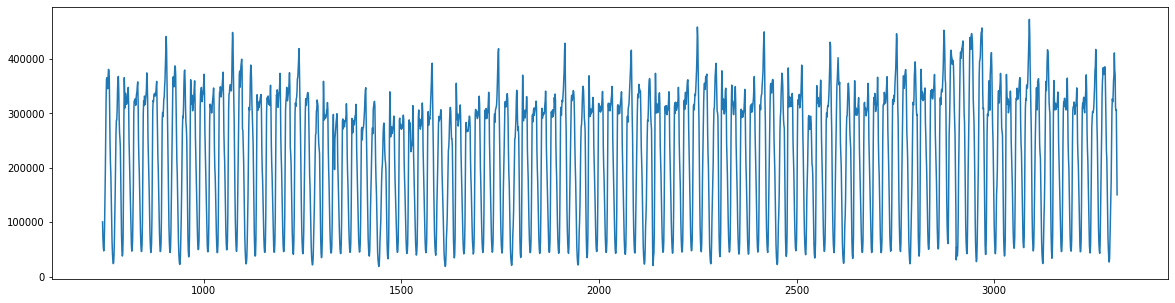

,datetime,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
744,2020-02-01 00:00:00,20200201,0,100593,17577,1307,4066,1434,968,34278,1267,2758,2004,16679,3841,5879,2369,7925,12179,1919,5766,22839,27713,13100,3213,2415,1201,43369,1069,3713,10662,7370,1220,4440,725,3012,1783,2623
745,2020-02-01 01:00:00,20200201,1,70732,12314,871,3441,846,821,25208,908,1860,1219,11236,3074,4264,1591,6828,8784,1567,4227,17295,19233,8831,2051,1591,900,29100,747,2568,7071,5153,881,3184,548,2029,1271,1905
746,2020-02-01 02:00:00,20200201,2,53857,8421,784,2863,612,548,18179,593,1697,1090,8375,2317,3251,1447,5352,7462,864,3743,13037,14562,7157,1461,1188,590,20426,523,1960,5254,3655,855,2597,447,1629,948,1587
747,2020-02-01 03:00:00,20200201,3,47215,9347,664,2097,515,548,15601,575,1534,1304,7488,2353,3371,1337,4839,7046,894,3842,11363,14935,6635,915,961,679,18000,456,1721,5111,3206,931,2502,393,1726,828,1553
748,2020-02-01 04:00:00,20200201,4,55504,14248,931,3109,640,616,20125,813,1565,1400,9032,3301,3681,1708,5441,8282,1388,5219,13254,19910,8583,1154,1143,1020,22647,665,2490,7075,3802,801,2609,556,2511,1233,2165


In [43]:
plt.figure(figsize=(20,5))
plt.plot(data_train["10"])
plt.show()
data_train.head()

In [44]:
data_train["date"] = data_train["datetime"]
data_train["date"] = pd.to_datetime(data_train["date"], format = '%Y-%m-%d %H')
data_train["value"] = data_train["10"]

scaler = StandardScaler()
scaler.fit(data_train["value"].to_numpy().reshape(-1,1))
data_train["value"] = scaler.transform(data_train["value"].to_numpy().reshape(-1,1)).reshape(-1)
data_train = data_train[["date", "value"]]

In [45]:
data_val = pd.read_csv("val_고침.csv")

data_val['날짜'] = data_val["날짜"].astype('int')
data_val['시간'] = data_val["시간"].astype('int')
data_val['date'] = data_val["날짜"] * 100 + data_val["시간"]

data_val['date'] = pd.to_datetime(data_val['date'], format="%Y%m%d%H")
data_val["value"] = data_val["10"]

data_val["value"] = scaler.transform(data_val["value"].to_numpy().reshape(-1,1)).reshape(-1)
data_val = data_val[["date", "value"]]

In [46]:
merged_data = pd.concat([data_train,data_val], ignore_index=True)

# 2. Train Model

## Set parameters & dataset

In [47]:
pred_len = 24*7

seq_len = pred_len # 인풋 크기
label_len = pred_len # 디코더에서 참고할 크기
pred_len = pred_len # 예측할 크기

batch_size = 16
shuffle_flag = True
num_workers = 0
drop_last = True

dataset = Dataset_Pred(dataframe=merged_data, size = (seq_len, label_len, pred_len))
data_loader = DataLoader(dataset,batch_size=batch_size,shuffle=shuffle_flag,num_workers=num_workers,drop_last=drop_last)

In [48]:
enc_in = 1
dec_in = 1
c_out = 1
EARLY_STOPPING_PATIENCE = 10
device = torch.device("cuda:0")

model = Informer(enc_in=enc_in, dec_in=dec_in, c_out=c_out, seq_len=seq_len, label_len=label_len, out_len=pred_len, d_ff=2048, device = device).to(device)
learning_rate = 1e-4

eps = 1e-6
criterion =  nn.MSELoss()

model_optim = optim.Adam(model.parameters(), lr=learning_rate)

In [49]:
class LossEarlyStopper():
    """Early stopper
    
    Attributes:
        patience (int): loss가 줄어들지 않아도 학습할 epoch 수
        patience_counter (int): loss 가 줄어들지 않을 때 마다 1씩 증가, 감소 시 0으로 리셋
        min_loss (float): 최소 loss
        stop (bool): True 일 때 학습 중단

    """

    def __init__(self, patience: int)-> None:
        self.patience = patience

        self.patience_counter = 0
        self.min_loss = np.Inf
        self.stop = False
        self.save_model = False

    def check_early_stopping(self, loss: float)-> None:
        """Early stopping 여부 판단"""  

        if self.min_loss == np.Inf:
            self.min_loss = loss
            return None

        elif loss > self.min_loss:
            self.patience_counter += 1
            msg = f"Early stopping counter {self.patience_counter}/{self.patience}"

            if self.patience_counter == self.patience:
                self.stop = True
                
        elif loss <= self.min_loss:
            self.patience_counter = 0
            self.save_model = True
            msg = f"Validation loss decreased {self.min_loss} -> {loss}"
            self.min_loss = loss
        
        print(msg)

In [50]:
early_stopper = LossEarlyStopper(patience=EARLY_STOPPING_PATIENCE)

In [51]:
train_epochs = 1000
model.train()
progress = tqdm(range(train_epochs))
for epoch in progress:
    train_loss = []
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
        model_optim.zero_grad()
        pred, true = _process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark)
        loss = torch.sqrt(criterion(pred, true) + eps)
        train_loss.append(loss.item())
        loss.backward()
        model_optim.step()
    train_loss = np.average(train_loss)

    early_stopper.check_early_stopping(loss=train_loss)

    if early_stopper.stop:
        print('Early stopped')
        break

    if early_stopper.save_model:
        torch.save(model.state_dict(), "informer_10.pt")
        early_stopper.save_model = False

    progress.set_description("loss: {:0.6f}".format(train_loss))

loss: 0.843793:   0%|          | 1/1000 [00:17<4:59:16, 17.97s/it]

Validation loss decreased 0.8437927518039942 -> 0.362832416780293


loss: 0.362832:   0%|          | 2/1000 [00:36<5:01:49, 18.15s/it]

Validation loss decreased 0.362832416780293 -> 0.2894507163204253


loss: 0.289451:   0%|          | 3/1000 [00:54<5:02:25, 18.20s/it]

Validation loss decreased 0.2894507163204253 -> 0.23483005044981836


loss: 0.234830:   0%|          | 4/1000 [01:12<5:02:31, 18.22s/it]

Validation loss decreased 0.23483005044981836 -> 0.2062765029259026


loss: 0.206277:   0%|          | 5/1000 [01:30<5:02:15, 18.23s/it]

Validation loss decreased 0.2062765029259026 -> 0.17777438852936028


loss: 0.177774:   1%|          | 6/1000 [01:49<5:02:06, 18.24s/it]

Validation loss decreased 0.17777438852936028 -> 0.16010304130613803


loss: 0.160103:   1%|          | 7/1000 [02:07<5:01:50, 18.24s/it]

Validation loss decreased 0.16010304130613803 -> 0.1499609389808029


loss: 0.149961:   1%|          | 8/1000 [02:25<5:01:37, 18.24s/it]

Validation loss decreased 0.1499609389808029 -> 0.1423294170293957


loss: 0.142329:   1%|          | 9/1000 [02:44<5:01:29, 18.25s/it]

Validation loss decreased 0.1423294170293957 -> 0.13013990460895003


loss: 0.130140:   1%|          | 10/1000 [03:02<5:01:17, 18.26s/it]

Validation loss decreased 0.13013990460895003 -> 0.12679078681394457


loss: 0.126791:   1%|          | 11/1000 [03:20<5:00:53, 18.25s/it]

Validation loss decreased 0.12679078681394457 -> 0.12050817012786866


loss: 0.120508:   1%|          | 12/1000 [03:38<5:00:31, 18.25s/it]

Validation loss decreased 0.12050817012786866 -> 0.11180918673053383


loss: 0.111809:   1%|▏         | 13/1000 [03:57<5:00:12, 18.25s/it]

Validation loss decreased 0.11180918673053383 -> 0.11152780209667981


loss: 0.111528:   1%|▏         | 14/1000 [04:15<5:00:02, 18.26s/it]

Validation loss decreased 0.11152780209667981 -> 0.11038413341157138


loss: 0.110384:   2%|▏         | 15/1000 [04:33<4:59:42, 18.26s/it]

Validation loss decreased 0.11038413341157138 -> 0.10336366854608059


loss: 0.103364:   2%|▏         | 16/1000 [04:51<4:59:27, 18.26s/it]

Validation loss decreased 0.10336366854608059 -> 0.09618960660882295


loss: 0.103051:   2%|▏         | 18/1000 [05:28<4:57:37, 18.19s/it]

Early stopping counter 1/10


loss: 0.097443:   2%|▏         | 19/1000 [05:46<4:56:14, 18.12s/it]

Early stopping counter 2/10
Validation loss decreased 0.09618960660882295 -> 0.08672939497046173


loss: 0.090033:   2%|▏         | 21/1000 [06:22<4:55:22, 18.10s/it]

Early stopping counter 1/10


loss: 0.090608:   2%|▏         | 22/1000 [06:40<4:54:24, 18.06s/it]

Early stopping counter 2/10
Validation loss decreased 0.08672939497046173 -> 0.08672094303183257


loss: 0.086721:   2%|▏         | 23/1000 [06:58<4:54:59, 18.12s/it]

Validation loss decreased 0.08672094303183257 -> 0.08557227030396461


loss: 0.086543:   2%|▎         | 25/1000 [07:34<4:54:17, 18.11s/it]

Early stopping counter 1/10
Validation loss decreased 0.08557227030396461 -> 0.08455782770179213


loss: 0.084558:   3%|▎         | 26/1000 [07:52<4:54:38, 18.15s/it]

Validation loss decreased 0.08455782770179213 -> 0.08198773032054305


loss: 0.081988:   3%|▎         | 27/1000 [08:11<4:54:52, 18.18s/it]

Validation loss decreased 0.08198773032054305 -> 0.07751874295063317


loss: 0.077519:   3%|▎         | 28/1000 [08:29<4:55:06, 18.22s/it]

Validation loss decreased 0.07751874295063317 -> 0.07563773372676223


loss: 0.077728:   3%|▎         | 30/1000 [09:05<4:53:37, 18.16s/it]

Early stopping counter 1/10
Validation loss decreased 0.07563773372676223 -> 0.07545871611218899


loss: 0.075459:   3%|▎         | 31/1000 [09:24<4:53:43, 18.19s/it]

Validation loss decreased 0.07545871611218899 -> 0.07545558344572782


loss: 0.075456:   3%|▎         | 32/1000 [09:42<4:53:44, 18.21s/it]

Validation loss decreased 0.07545558344572782 -> 0.07010229190345854


loss: 0.074882:   3%|▎         | 34/1000 [10:18<4:52:13, 18.15s/it]

Early stopping counter 1/10
Validation loss decreased 0.07010229190345854 -> 0.06867914407048374


loss: 0.070308:   4%|▎         | 36/1000 [10:54<4:51:15, 18.13s/it]

Early stopping counter 1/10


loss: 0.072513:   4%|▎         | 37/1000 [11:12<4:50:08, 18.08s/it]

Early stopping counter 2/10


loss: 0.068874:   4%|▍         | 38/1000 [11:30<4:49:14, 18.04s/it]

Early stopping counter 3/10
Validation loss decreased 0.06867914407048374 -> 0.06637336167041212


loss: 0.066488:   4%|▍         | 40/1000 [12:06<4:48:59, 18.06s/it]

Early stopping counter 1/10
Validation loss decreased 0.06637336167041212 -> 0.0638845736393705


loss: 0.063885:   4%|▍         | 41/1000 [12:25<4:49:39, 18.12s/it]

Validation loss decreased 0.0638845736393705 -> 0.06373036776203662


loss: 0.063730:   4%|▍         | 42/1000 [12:43<4:50:13, 18.18s/it]

Validation loss decreased 0.06373036776203662 -> 0.059033584082499146


loss: 0.060584:   4%|▍         | 44/1000 [13:19<4:49:14, 18.15s/it]

Early stopping counter 1/10


loss: 0.060354:   4%|▍         | 45/1000 [13:37<4:48:01, 18.10s/it]

Early stopping counter 2/10


loss: 0.060189:   5%|▍         | 46/1000 [13:55<4:47:01, 18.05s/it]

Early stopping counter 3/10


loss: 0.060293:   5%|▍         | 47/1000 [14:13<4:46:17, 18.02s/it]

Early stopping counter 4/10


loss: 0.059103:   5%|▍         | 48/1000 [14:31<4:45:43, 18.01s/it]

Early stopping counter 5/10
Validation loss decreased 0.059033584082499146 -> 0.05722723782528192


loss: 0.057227:   5%|▍         | 49/1000 [14:49<4:46:36, 18.08s/it]

Validation loss decreased 0.05722723782528192 -> 0.056290153856389226


loss: 0.056290:   5%|▌         | 50/1000 [15:08<4:47:15, 18.14s/it]

Validation loss decreased 0.056290153856389226 -> 0.05540868490934372


loss: 0.055533:   5%|▌         | 52/1000 [15:44<4:46:21, 18.12s/it]

Early stopping counter 1/10
Validation loss decreased 0.05540868490934372 -> 0.05517266874667257


loss: 0.055173:   5%|▌         | 53/1000 [16:02<4:46:31, 18.15s/it]

Validation loss decreased 0.05517266874667257 -> 0.052644889312796296


loss: 0.052955:   6%|▌         | 55/1000 [16:38<4:45:40, 18.14s/it]

Early stopping counter 1/10


loss: 0.055932:   6%|▌         | 56/1000 [16:56<4:44:34, 18.09s/it]

Early stopping counter 2/10


loss: 0.054394:   6%|▌         | 57/1000 [17:14<4:43:40, 18.05s/it]

Early stopping counter 3/10
Validation loss decreased 0.052644889312796296 -> 0.05064222814980894


loss: 0.050642:   6%|▌         | 58/1000 [17:33<4:44:07, 18.10s/it]

Validation loss decreased 0.05064222814980894 -> 0.04953637078870088


loss: 0.051084:   6%|▌         | 60/1000 [18:09<4:43:44, 18.11s/it]

Early stopping counter 1/10


loss: 0.049931:   6%|▌         | 61/1000 [18:27<4:42:51, 18.07s/it]

Early stopping counter 2/10
Validation loss decreased 0.04953637078870088 -> 0.0469064406119287


loss: 0.047914:   6%|▋         | 63/1000 [19:03<4:42:39, 18.10s/it]

Early stopping counter 1/10


loss: 0.049718:   6%|▋         | 64/1000 [19:21<4:41:42, 18.06s/it]

Early stopping counter 2/10


loss: 0.046987:   6%|▋         | 65/1000 [19:39<4:41:04, 18.04s/it]

Early stopping counter 3/10
Validation loss decreased 0.0469064406119287 -> 0.04581263535656035


loss: 0.045813:   7%|▋         | 66/1000 [19:57<4:41:44, 18.10s/it]

Validation loss decreased 0.04581263535656035 -> 0.04368049504701048


loss: 0.045490:   7%|▋         | 68/1000 [20:34<4:41:20, 18.11s/it]

Early stopping counter 1/10


loss: 0.047705:   7%|▋         | 69/1000 [20:52<4:40:23, 18.07s/it]

Early stopping counter 2/10


loss: 0.060738:   7%|▋         | 70/1000 [21:10<4:39:44, 18.05s/it]

Early stopping counter 3/10


loss: 0.053487:   7%|▋         | 71/1000 [21:28<4:38:58, 18.02s/it]

Early stopping counter 4/10


loss: 0.047979:   7%|▋         | 72/1000 [21:46<4:38:22, 18.00s/it]

Early stopping counter 5/10


loss: 0.045612:   7%|▋         | 73/1000 [22:03<4:37:58, 17.99s/it]

Early stopping counter 6/10


loss: 0.046200:   7%|▋         | 74/1000 [22:21<4:37:31, 17.98s/it]

Early stopping counter 7/10


loss: 0.046414:   8%|▊         | 75/1000 [22:39<4:36:57, 17.97s/it]

Early stopping counter 8/10


loss: 0.046228:   8%|▊         | 76/1000 [22:57<4:36:30, 17.96s/it]

Early stopping counter 9/10


loss: 0.046228:   8%|▊         | 76/1000 [23:15<4:42:49, 18.37s/it]

Early stopping counter 10/10
Early stopped


# 3. Prediction

## Load model

In [52]:
model = Informer(enc_in=enc_in, dec_in=dec_in, c_out=c_out, seq_len=seq_len, label_len=label_len, out_len=pred_len, d_ff=2048, device = device).to(device)
model.load_state_dict(torch.load("informer_10.pt", map_location='cpu'))

<All keys matched successfully>

## Load test data & prediction

In [58]:
df_test = merged_data.copy()
df_test["date"] = pd.to_datetime(df_test["date"].values)

delta = df_test["date"][1] - df_test["date"][0]
for i in range(pred_len):
    df_test = df_test.append({"date":df_test["date"].iloc[-1]+delta}, ignore_index=True)
df_test = df_test.fillna(0)

df_test_x = df_test.iloc[-seq_len-pred_len:-pred_len].copy()
df_test_y = df_test.iloc[-label_len-pred_len:].copy()

df_test_numpy = df_test.to_numpy()[:,1:].astype("float")
test_time_x = time_features(df_test_x, freq=dataset.freq) # 인풋 타임 스템프
test_data_x = df_test_numpy[-seq_len-pred_len:-pred_len] # 인풋 데이터

test_time_y = time_features(df_test_y, freq=dataset.freq) # 아웃풋 타임스템프
test_data_y =df_test_numpy[-label_len-pred_len:]
test_data_y[-pred_len:] = np.zeros_like(test_data_y[-pred_len:]) #예측하는 부분을 0으로 채워준다.

test_time_x = test_time_x
test_time_y = test_time_y
test_data_y = test_data_y.astype(np.float64)
test_data_x = test_data_x.astype(np.float64)

_test = [(test_data_x,test_data_y,test_time_x,test_time_y)]
_test_loader = DataLoader(_test,batch_size=1,shuffle=False)

preds = []

for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(_test_loader):

    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float().to(device)

    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)

    outputs = model(batch_x, batch_x_mark, batch_y, batch_y_mark)
    preds = outputs.detach().cpu().numpy()

df_test['value'] = scaler.inverse_transform(df_test['value'])
preds = scaler.inverse_transform(preds[0])

df_test.iloc[-pred_len:, 1:] = preds

## See result

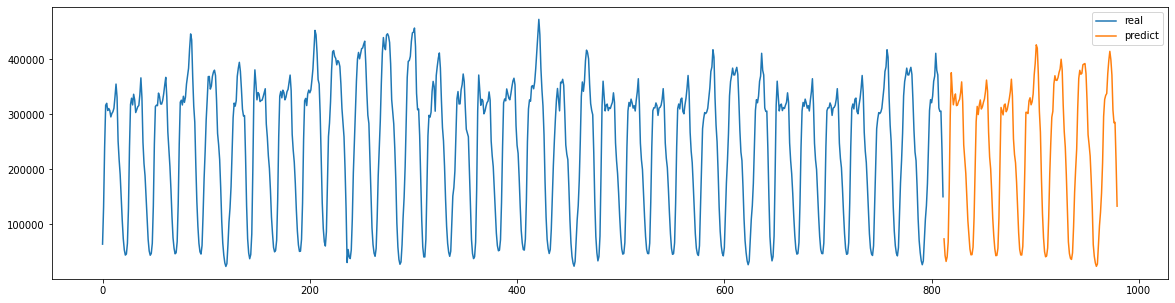

In [61]:
real = df_test["value"].iloc[:-24*7].to_numpy()
result = df_test["value"].iloc[-24*7:].to_numpy()

plt.figure(figsize=(20,5))
plt.plot(real[-812-+24*7:-24*7], label="real")
plt.plot(range(812,812+24*7), result, label="predict")
plt.legend()
plt.show()

# 4. Save result

In [62]:
result10 = pd.DataFrame(result)

In [63]:
result10

,0
0,73742.431820
1,43510.480091
2,32776.136804
3,40949.475299
4,68074.422278
...,...
163,307744.459491
164,284728.514887
165,285580.543575
166,214649.314970


In [ ]:
result10.to_csv('10.csv')